# Check that extend fill into cavities actually worked

In [21]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cmocean
import tqdm
import cartopy.crs as ccrs
import sys
import numpy.ma as ma
sys.path.append('/home/users/birgal/')
# from nemo_python.interpolation import interp_latlon_cf, neighbours, neighbours_z, extend_into_mask

Load files

In [2]:
domcfg_new = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/domain_cfg-20231025.nc').isel(x=slice(350,500), y=slice(120,200))
mask_new   = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/bathymetry/mesh_mask-20231025.nc').isel(x=slice(350,500), y=slice(120,200))
IC_S       = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/SOSE-SALT-initial-conditions.nc').isel(x=slice(350,500), y=slice(120,200))
IC_start   = xr.open_dataset('/gws/nopw/j04/terrafirma/birgal/NEMO_AIS/initial-conditions/temp/SOSE-SALT-vertical-interp.nc').isel(x=slice(350,500), y=slice(120,200))

In [206]:
# Finds the value of the given array to the west, east, south, north of every point, as well as which neighbours are non-missing, and how many neighbours are non-missing.
def neighbours (data, missing_val=-9999):

    # Find the value to the west, east, south, north of every point
    # Just copy the boundaries
    data_w          = np.empty(data.shape)
    data_w[...,1:]  = data[...,:-1]
    data_w[...,0]   = data[...,0]
    data_e          = np.empty(data.shape)
    data_e[...,:-1] = data[...,1:]
    data_e[...,-1]  = data[...,-1]
    
    data_s            = np.empty(data.shape)
    data_s[...,1:,:]  = data[...,:-1,:]
    data_s[...,0,:]   = data[...,0,:]
    data_n            = np.empty(data.shape)
    data_n[...,:-1,:] = data[...,1:,:]
    data_n[...,-1,:]  = data[...,-1,:]     
        
    # Arrays of 1s and 0s indicating whether these neighbours are non-missing
    valid_w = ((data_w != missing_val)*~np.isnan(data_w)).astype(float)
    valid_e = ((data_e != missing_val)*~np.isnan(data_e)).astype(float)
        
    valid_s = ((data_s != missing_val)*~np.isnan(data_s)).astype(float)
    valid_n = ((data_n != missing_val)*~np.isnan(data_n)).astype(float)
    
    num_valid_neighbours = valid_w + valid_e + valid_s + valid_n
    
    return data_w, data_e, data_s, data_n, valid_w, valid_e, valid_s, valid_n, num_valid_neighbours

In [185]:
data_unmasked = src_to_fill.data
data_unmasked[src_to_fill.mask] = -9999
data = data_unmasked
data_w          = np.empty(data.shape)
data_w[...,1:]  = data[...,:-1]
data_w[...,0]   = data[...,0]

In [202]:
valid_w = ((data_w != -9999)*~np.isnan(data_w)).astype(float)

In [203]:
data[0,35:60,120]

array([           nan,            nan,            nan,            nan,
                  nan,            nan, -9999.        , -9999.        ,
       -9999.        , -9999.        , -9999.        , -9999.        ,
       -9999.        , -9999.        , -9999.        , -9999.        ,
          31.53593046,    31.7773323 ,    31.96492431,    32.06275331,
          32.11772736,    32.15651141,    32.17749424,    32.19356601,
          32.21261295])

In [204]:
data_w[0,35:60,120]

array([           nan,            nan,            nan,            nan,
                  nan,            nan, -9999.        , -9999.        ,
       -9999.        , -9999.        , -9999.        , -9999.        ,
       -9999.        , -9999.        , -9999.        , -9999.        ,
          31.56390435,    31.81502447,    31.9941947 ,    32.07756786,
          32.11185405,    32.13672313,    32.15261083,    32.1718159 ,
          32.19934054])

In [205]:
valid_w[0,35:60,120]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1.])

In [207]:
# Like the neighbours function, but in the vertical dimension: neighbours above and below
def neighbours_z (data, missing_val=-9999):

    data_u              = np.empty(data.shape)
    data_u[...,1:,:,:]  = data[...,:-1,:,:]
    data_u[...,0,:,:]   = data[...,0,:,:]
    
    data_d              = np.empty(data.shape)
    data_d[...,:-1,:,:] = data[...,1:,:,:]
    data_d[...,-1,:,:]  = data[...,-1,:,:]
    valid_u = ((data_u  != missing_val)*~np.isnan(data_u)).astype(float)
    valid_d = ((data_d  != missing_val)*~np.isnan(data_d)).astype(float)
    
    num_valid_neighbours_z = valid_u + valid_d
    
    return data_u, data_d, valid_u, valid_d, num_valid_neighbours_z

In [243]:
def extend_into_mask (data, missing_val=-9999, masked=False, use_1d=False, use_2d=False, use_3d=False, preference='horizontal', num_iters=100):

    if masked:
        # MaskedArrays will mess up the extending
        # Unmask the array and fill the mask with missing values
        data_unmasked = data.data
        data_unmasked[data.mask] = missing_val
        data = data_unmasked

    for iter in range(num_iters):
        # Find the neighbours of each point, whether or not they are missing, and how many non-missing neighbours there are.
        # Then choose the points that can be filled.
        # Then set them to the average of their non-missing neighbours.
        # Consider horizontal neighbours in both directions
        data_w, data_e, data_s, data_n, valid_w, valid_e, valid_s, valid_n, num_valid_neighbours = neighbours(data, missing_val=missing_val)
        # for i, pair in enumerate(zip(num_valid_neighbours[44,20:40,120], data[44,20:40,120])):
        #     if iter > num_iters-3:
        #         print(i, pair)    
        # if iter >  num_iters-3:  
        #     print('----')
        index = (data == missing_val)*(num_valid_neighbours > 0)
        data[index] = (data_w[index]*valid_w[index] + data_e[index]*valid_e[index] + data_s[index]*valid_s[index] + data_n[index]*valid_n[index])/num_valid_neighbours[index]
        
        if use_3d:
            # Look for vertical neighbours
            data_d, data_u, valid_d, valid_u, num_valid_neighbours_new = neighbours_z(data, missing_val=missing_val)
            index = (data == missing_val)*(num_valid_neighbours == 0)*(num_valid_neighbours_new > 0)
            data[index] = (data_u[index]*valid_u[index] + data_d[index]*valid_d[index])/num_valid_neighbours_new[index]
                
    if masked:
        # Remask the MaskedArray
        data = ma.masked_where(data==missing_val, data)

    return data   

In [217]:
# missing     = xr.where((mask_new.tmask.isel(time_counter=0)==1).values * (np.isnan(IC_start['SALT'].values)), 1, 0)
# src_to_fill = np.ma.masked_where(missing==1, IC_start['SALT'].values)    

# var_filled = extend_into_mask(src_to_fill, use_2d=False, use_3d=True, masked=True, num_iters=100)

In [246]:
missing     = xr.where((mask_new.tmask.isel(time_counter=0)==1).values * (np.isnan(IC_start['SALT'].values)), 1, 0)
src_to_fill = np.ma.masked_where(missing==1, IC_start['SALT'].values) 

var_filled = extend_into_mask(src_to_fill, use_2d=False, use_3d=True, masked=True, num_iters=100)

(0.0, 80.0)

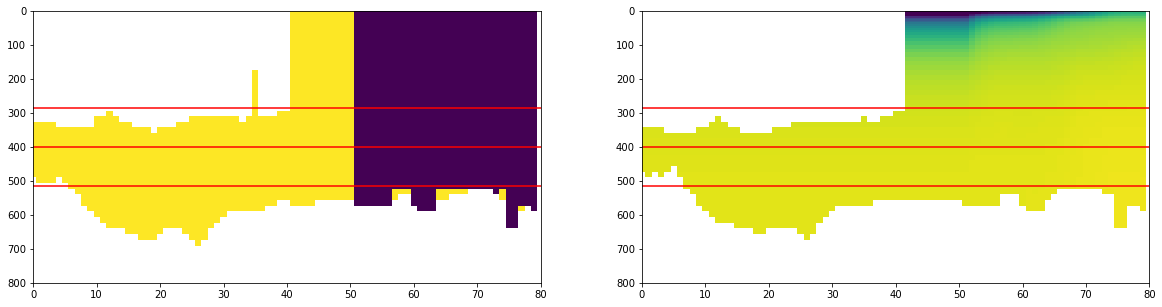

In [255]:
not_filled = xr.where((mask_new.tmask.isel(time_counter=0)==1) * (np.isnan(IC_start['SALT'].values)), 1, 0)
srctofill  = xr.where(not_filled==1, 1000, IC_start['SALT'].values)

fig, ax = plt.subplots(1,2, figsize=(20,5))
ax[0].pcolormesh(srctofill.isel(x=120).y, srctofill.isel(x=120).nav_lev, srctofill.isel(x=120))
ax[0].plot([0,80],[srctofill.nav_lev[44], srctofill.nav_lev[44]],'-r')
ax[0].plot([0,80],[srctofill.nav_lev[37], srctofill.nav_lev[37]],'-r')
ax[0].plot([0,80],[srctofill.nav_lev[51], srctofill.nav_lev[51]],'-r')
# ax[0].pcolormesh(data_unmasked[:,:,120])
ax[0].set_ylim(800,0); ax[0].set_xlim(0,80)

ax[1].pcolormesh(srctofill.isel(x=120).y, srctofill.isel(x=120).nav_lev, var_filled[:,:,120], vmin=32, vmax=35)
ax[1].plot([0,80],[srctofill.nav_lev[44], srctofill.nav_lev[44]],'-r')
ax[1].plot([0,80],[srctofill.nav_lev[37], srctofill.nav_lev[37]],'-r')
ax[1].plot([0,80],[srctofill.nav_lev[51], srctofill.nav_lev[51]],'-r')
ax[1].set_ylim(800,0); ax[1].set_xlim(0,80)

In [40]:
# def fill_mask(input_dataset, variable, nemo_mask, fill_val=1000, niter=2):
    
#     # nemo_ocn = (nemo_mask.tmask.isel(time_counter=0).values == 1)

#     not_filled = xr.where((nemo_mask.tmask.isel(time_counter=0, nav_lev=0)==1).values * (np.isnan(input_dataset[variable].values)), 1, 0)

#     # print('input variable shape: ', input_dataset[variable].values.shape)
#     src_to_fill = np.ma.masked_where(not_filled==1, input_dataset[variable].values)    
#     # print('src_to_fill shape: ', src_to_fill.shape)
#     # src_to_fill  = xr.where(np.isnan(input_dataset[variable].values)*nemo_ocn, fill_val, input_dataset[variable].values)
#     # src_to_fill  = xr.where(np.isnan(input_dataset[variable].values), fill_val, input_dataset[variable].values)
#     # src_to_fill  = xr.where(~nemo_ocn, np.nan, src_to_fill)
#     # var_filled   = extend_into_mask(src_to_fill, use_2d=False, use_3d=True, masked=True)
#     var_filled   = extend_into_mask(src_to_fill, use_2d=True, use_3d=False, masked=True)
#     # print('src_to_fill shape: ', var_filled.shape)
    
#     for iter in tqdm.tqdm(range(niter)):
#         # if np.sum(var_filled==fill_val) == 0: # stop looping if all missing values have been filled
#         #     break
#         # else:
#             # not_filled = xr.where((nemo_mask.tmask.isel(time_counter=0)==1).values * np.isnan(var_filled), 1, 0)
#             # var_to_fill = xr.where(not_filled==1, fill_val, var_filled)    
#         # var_filled = extend_into_mask(var_filled, use_2d=False, use_3d=True, masked=True)
#         var_filled = extend_into_mask(var_filled, use_2d=True, use_3d=False, masked=True) 

#     # input_dataset[variable] = (('z','y','x'), var_filled)
#     input_dataset[variable] = (('y','x'), var_filled)
        
#     return input_dataset 

In [41]:
not_filled  = xr.where((mask_new.tmask.isel(time_counter=0)==1).values * (np.isnan(IC_start.SALT.values)), 1, 0)
src_to_fill = np.ma.masked_where(not_filled==1, IC_start.SALT.isel(z=0).values)  

data_unmasked = src_to_fill.data
data_unmasked[src_to_fill.mask] = 1000
data = data_unmasked

In [5]:
src_to_fill.shape

NameError: name 'src_to_fill' is not defined

In [42]:
fill1 = fill_mask(IC_start.isel(z=0), 'SALT', mask_new)

100%|██████████| 2/2 [00:00<00:00, 1360.24it/s]


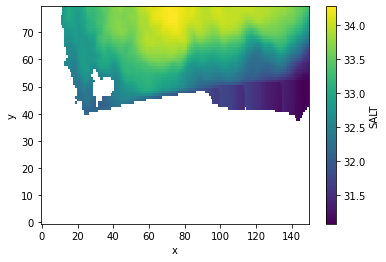

In [44]:
fill1.SALT.plot()

In [ ]:
data_next_step = ma.masked_where(data==1000, data)

Text(0.5, 1.0, 'Top down view')

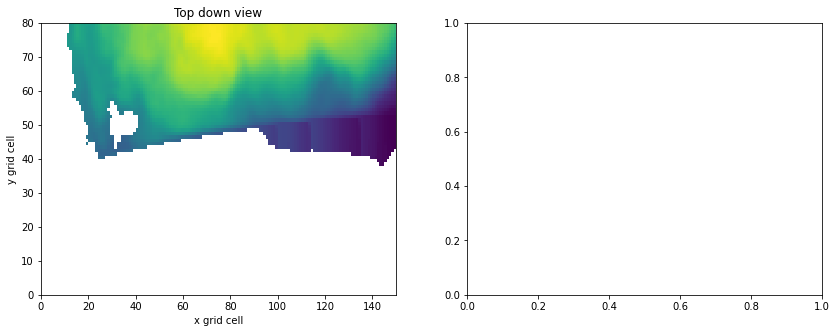

In [37]:

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].pcolormesh(fill1.SALT);
ax[0].set_ylabel('y grid cell')
ax[0].set_xlabel('x grid cell')
ax[0].set_title('Top down view')

Text(0.5, 1.0, 'Transect view')

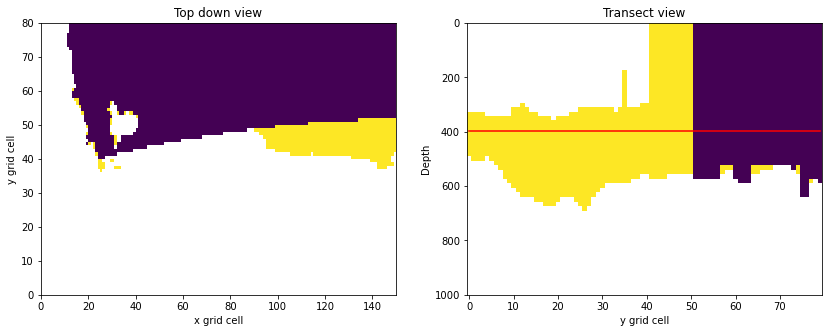

In [220]:
not_filled  = xr.where((mask_new.tmask.isel(time_counter=0)==1) * (np.isnan(IC_start['SALT'].values)), 1, 0)
src_to_fill = xr.where(not_filled==1, 1000, IC_start['SALT'].values)

fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].pcolormesh(src_to_fill.isel(nav_lev=0));
ax[0].set_ylabel('y grid cell')
ax[0].set_xlabel('x grid cell')
ax[0].set_title('Top down view')

ax[1].pcolormesh(src_to_fill.isel(x=120).y, src_to_fill.isel(x=120).nav_lev, src_to_fill.isel(x=120))
ax[1].plot([src_to_fill.isel(x=120).y.values[0], src_to_fill.isel(x=120).y.values[-1]],
           [src_to_fill.isel(x=120).nav_lev.values[44], src_to_fill.isel(x=120).nav_lev.values[44]], '-r')
ax[1].set_ylabel('Depth')
ax[1].set_xlabel('y grid cell')
ax[1].set_ylim(1000,0)
ax[1].set_title('Transect view')

Text(0.5, 1.0, 'Transect view')

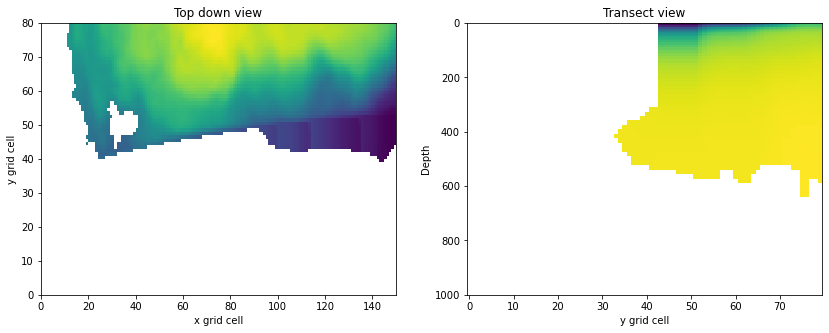

In [21]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].pcolormesh(fill1.SALT.isel(z=0));
ax[0].set_ylabel('y grid cell')
ax[0].set_xlabel('x grid cell')
ax[0].set_title('Top down view')

# plot_var = xr.where(fill1.SALT.isel(x=120) == 1000, np.nan, fill1.SALT.isel(x=120))
ax[1].pcolormesh(fill1.isel(x=120).y, src_to_fill.isel(x=120).nav_lev, fill1.SALT.isel(x=120))
ax[1].set_ylabel('Depth')
ax[1].set_xlabel('y grid cell')
ax[1].set_ylim(1000,0)
ax[1].set_title('Transect view')

Text(0.5, 1.0, 'Transect view')

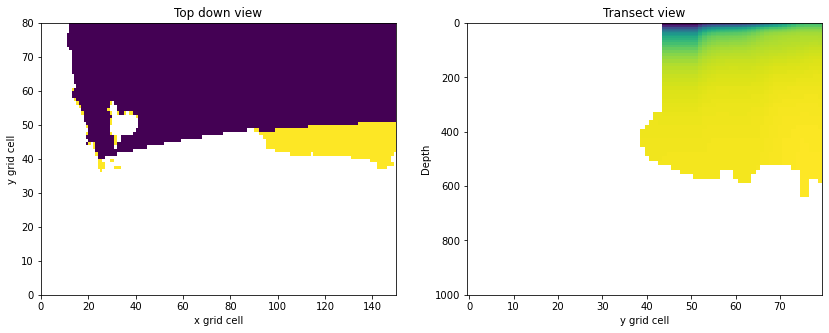

In [16]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].pcolormesh(src_to_fill.isel(nav_lev=0));
ax[0].set_ylabel('y grid cell')
ax[0].set_xlabel('x grid cell')
ax[0].set_title('Top down view')

# plot_var = xr.where(fill1.SALT.isel(x=120) == 1000, np.nan, fill1.SALT.isel(x=120))
ax[1].pcolormesh(fill1.isel(x=120).y, src_to_fill.isel(x=120).nav_lev, fill1.SALT.isel(x=120))
ax[1].set_ylabel('Depth')
ax[1].set_xlabel('y grid cell')
ax[1].set_ylim(1000,0)
ax[1].set_title('Transect view')

Text(0.5, 1.0, 'Transect view')

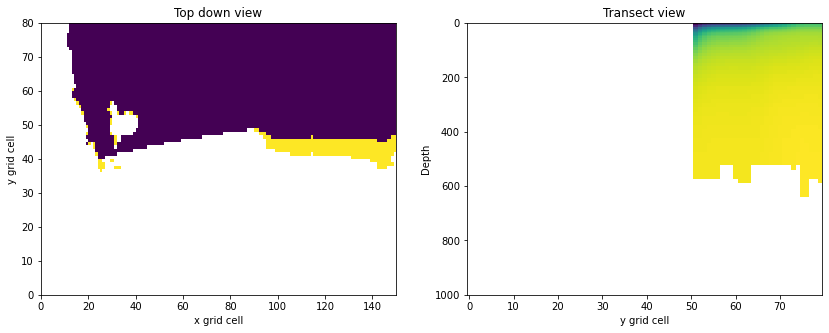

In [64]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].pcolormesh(src_to_fill.isel(nav_lev=0));
ax[0].set_ylabel('y grid cell')
ax[0].set_xlabel('x grid cell')
ax[0].set_title('Top down view')

ax[1].pcolormesh(IC_start.isel(x=120).y, src_to_fill.isel(x=120).nav_lev, IC_start.SALT.isel(x=120))
ax[1].set_ylabel('Depth')
ax[1].set_xlabel('y grid cell')
ax[1].set_ylim(1000,0)
ax[1].set_title('Transect view')

Text(0.5, 1.0, 'Transect view')

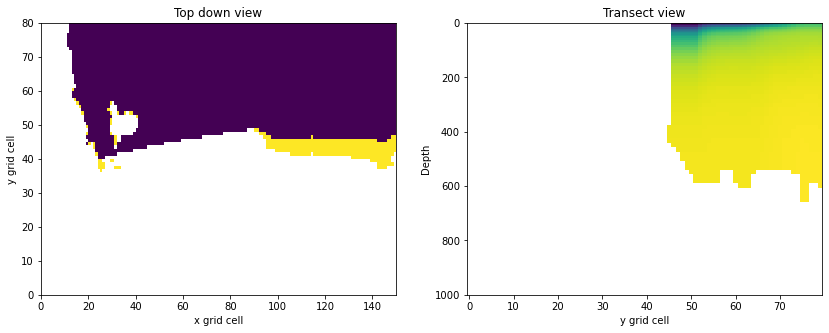

In [65]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].pcolormesh(src_to_fill.isel(nav_lev=0));
ax[0].set_ylabel('y grid cell')
ax[0].set_xlabel('x grid cell')
ax[0].set_title('Top down view')

ax[1].pcolormesh(IC_S.isel(x=120).y, src_to_fill.isel(x=120).nav_lev, IC_S.SALT.isel(x=120))
ax[1].set_ylabel('Depth')
ax[1].set_xlabel('y grid cell')
ax[1].set_ylim(1000,0)
ax[1].set_title('Transect view')

Text(0.5, 1.0, 'Top down view')

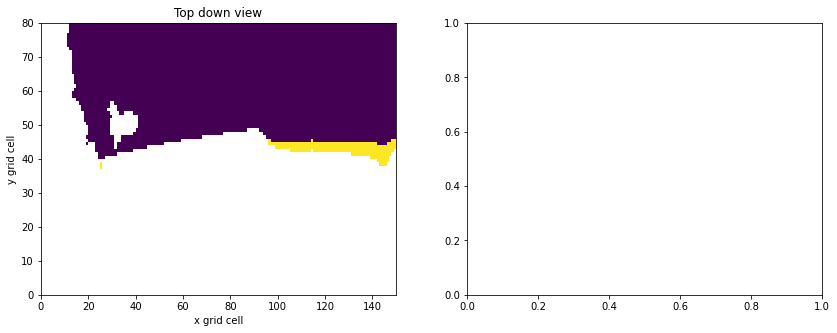

In [51]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
ax[0].pcolormesh(var_filled[0,:,:]);
ax[0].set_ylabel('y grid cell')
ax[0].set_xlabel('x grid cell')
ax[0].set_title('Top down view')

# ax[1].pcolormesh(var_filled[:,:,120], var_filled[:,:,120]src_to_fill.isel(x=120).nav_lev, src_to_fill.isel(x=120))
# ax[1].plot([var_filled.isel(x=120).y.values[0], src_to_fill.isel(x=120).y.values[-1]],
#            [var_filled.isel(x=120).nav_lev.values[44], src_to_fill.isel(x=120).nav_lev.values[44]], '-r')
# ax[1].set_ylabel('Depth')
# ax[1].set_xlabel('y grid cell')
# ax[1].set_ylim(1000,0)
# ax[1].set_title('Transect view')

In [52]:
var_filled  = extend_into_mask(src_to_fill.values, missing_val=1000, use_2d=False, use_3d=True)

In [47]:
# salt_filled = fill_mask(IC_S, 'SALT', mask_new)

In [44]:
not_filled = xr.where((mask_new.tmask.isel(time_counter=0)==1) * (np.isnan(IC_S.SALT.values)), 1, 0)

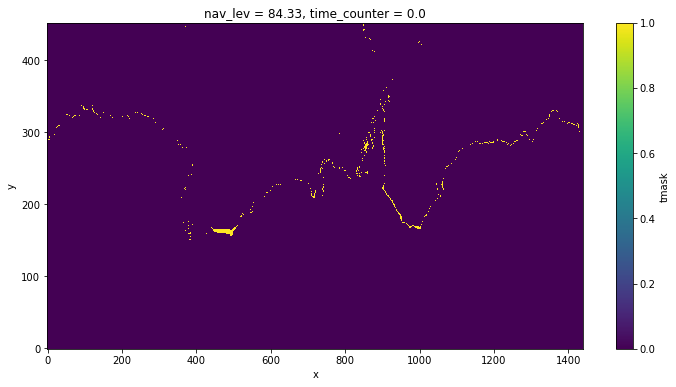

In [7]:
not_filled.isel(nav_lev=22).plot(figsize=(12,6))

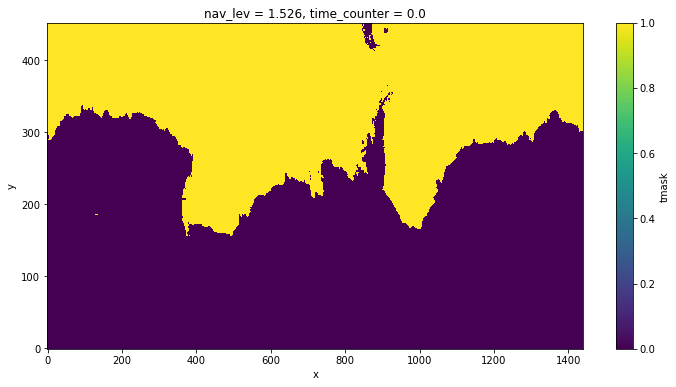

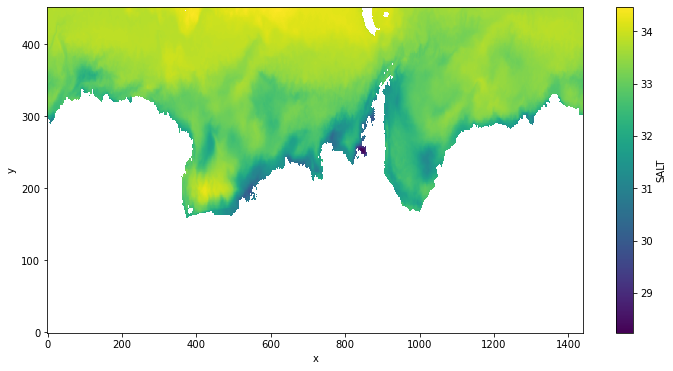

In [36]:
mask_new.tmask.isel(time_counter=0, nav_lev=1).plot(figsize=(12,6))
salt_filled.SALT.isel(z=0).plot(figsize=(12,6))